In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow import set_random_seed
from numpy.random import seed
from datetime import datetime

# set numpy seed for reproducibility
seed(1)
# set tf seed for reproducibility
set_random_seed(2)
#
# Turn off GPU usage for tf
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#

In [2]:
# Read the previously saved dataframe
df_covtype_ohe = pd.read_csv(os.path.join(os.getcwd(), 'covtype_ohe.csv'), dtype=np.float32)

In [ ]:
#df_covtype_ohe.head(2)

In [3]:
def train_test_split(df_covtype_ohe):
    '''
    Split the one hot encoded dataset onto training set and test set
    according to UCI's repository guidelines
    '''
    # First 15120 rows for the training set
    X_train = df_covtype_ohe[:15120].copy()
    # The last seven colums are the targets
    X_train, y_train = X_train.iloc[:, :51], X_train.iloc[:, 51:]
    # The remaining rows are for the test set
    X_test = df_covtype_ohe[15120:].copy()
    X_test, y_test = X_test.iloc[:, :51], X_test.iloc[:, 51:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df_covtype_ohe)

In [ ]:
# Check shapes consistency
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, ' \
      f'y_train: {y_train.shape}, y_test: {y_test.shape}')

In [4]:
# Let's standardize the training set and test set.
# Note that we use the training set ONLY to calculate the mean and standard deviation
# then normalize the training set 
# and finally use the (training) mean and standard deviation to normalize the test set.
# This ensures no data leakage.

def train_test_normalize(X_train, X_test):
    '''
    Perform standardization on the training set and transforms the
    test set accordingly
    '''
    # The numerical columns we want to normalize
    numerical_columns = ['Elevation',
                         'Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways',
                         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                         'Horizontal_Distance_To_Fire_Points']
    # Calculate the mean and standard deviation of the training set
    X_train_num_cols_mean = X_train[numerical_columns].mean()
    X_train_num_cols_std = X_train[numerical_columns].std()
    # Perform standardization over the numerical columns of the training set
    X_train_std = (X_train[numerical_columns] - X_train_num_cols_mean) / X_train_num_cols_std
    # Concatenate side-by-side the normalized training set and the one-hot encoded features
    # Note that we index X_train dataframe by the (set) difference of the overall features
    # minus the numerical ones
    ohe_features = X_train.columns.difference(other=numerical_columns, sort=False)
    X_train_std = pd.concat([X_train_std, X_train[ohe_features]], axis=1)
    # Perform standardization over the numerical columns of the test set, using the mean and std
    # of the training set as discussed earlier
    X_test_std = (X_test[numerical_columns] - X_train_num_cols_mean) / X_train_num_cols_std
    # Concatenate side-by-side the normalized test set and the one-hot encoded features
    X_test_std = pd.concat([X_test_std, X_test[ohe_features]], axis=1)
    return X_train_std, X_test_std

X_train_std, X_test_std = train_test_normalize(X_train, X_test)

In [5]:
# Convert train/test sets to numpy float32 ndarrays
# (after doing some research it appears that float32 should be used when using a GPU)
X_train_std = X_train_std.to_numpy().astype(np.float32)
X_test_std = X_test_std.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_test = y_test.to_numpy().astype(np.float32)

In [6]:
# Initialize the training/validation set splitter.
# We'll use it later for the grid-search, performing a 10-fold cross validation
# where each validation set is 25% the size of the training set.
# This yields 1620 samples per class for the new training set and
# 540 samples per class for each validation set.
validation_strat = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=10)

In [7]:
# Subclass KerasClassifier and override fit() method
# to fix OOM error when running sklearn GridSearchCV on the GPU
class GridKerasClassifier(keras.wrappers.scikit_learn.KerasClassifier):
    def fit(self, *args, **kwargs):
        # Clear tensorflow session each time fit is invoked
        keras.backend.clear_session()
        # Use custom configuration for the new session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        keras.backend.set_session(session)
        super().fit(*args, **kwargs)

In [ ]:
# Wrapper function which builds the classifier architecture of the baseline model.
def baseline_model(hidden_layers=0, h1_size=120, h2_size=0,
                   n_features=51, n_classes=7, learning_rate=0.5):
    model = keras.Sequential()
    model.add(keras.layers.Dense(h1_size, activation='sigmoid', input_dim=n_features))
    model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
    sgd = keras.optimizers.SGD(lr=learning_rate)
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
    return model

In [8]:
# Wrapper function which builds the classifier architecture of the model
# similar to the baseline one.
def crossentropy_model(hidden_layers=0, h1_size=120, h2_size=0,
                       n_features=51, n_classes=7, learning_rate=0.5):
    model = keras.Sequential()
    model.add(keras.layers.Dense(h1_size, activation='relu', input_dim=n_features))
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    sgd = keras.optimizers.SGD(lr=learning_rate)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Wrapper function which builds the classifier architecture of a two hidden layer model
def multi_hidden_model(hidden_layers=1, h1_size=120, h2_size=1,
                       n_features=51, n_classes=7, learning_rate=0.5):
    model = keras.Sequential()
    model.add(keras.layers.Dense(h1_size, activation='relu', input_dim=n_features))
    if hidden_layers > 1:
        for i in range(hidden_layers):
            # Add multiple hidden layers after the first one.
            model.add(keras.layers.Dense(h2_size, activation='relu'))
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    sgd = keras.optimizers.SGD(lr=learning_rate)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Wrap the Keras neural network onto a scikit Classifier
net_to_gs = GridKerasClassifier(crossentropy_model)

# For params tuning see
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Define the grid search params
# uncomment for changing the default number of features and/or classes
# for the network. DON'T FORGET TO CHANGE THE TRAINING/TEST SET ACCORDINGLY!
# n_features = [X_train_std.shape[1]]
# n_classes = [y_train.shape[1]]
hidden_layers = [1]
h1_size = [120]
h2_size = [0]
learning_rate = [0.5]
# 128 seems to work well
batch_size = [128]
epochs = [200, 500]
# Define the grid of parameters 
param_grid = dict(# n_features=n_features, # uncomment if needed
                  # n_classes=n_classes,   # uncomment if needed
                  hidden_layers=hidden_layers,
                  h1_size=h1_size,
                  h2_size=h2_size,
                  learning_rate=learning_rate,
                  batch_size=batch_size,
                  epochs=epochs)
# Initialize the grid search using the nn classifier and the cross-validation
# strategy defined above. Since clear_session() is invoked after each CV run,
# it's fine to set n_jobs=-1 when running on the GPU.
grid = GridSearchCV(estimator=net_to_gs,
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=validation_strat,
                    verbose=0)

In [13]:
# Run grid search
# THIS CELL IS TIME CONSUMING, BE AWARE OF THAT!
grid.fit(X_train_std, y_train)
# Store the best model in the current dir
#now = datetime.now()
#timestamp = now.strftime('%b-%d-%Y_%H%M')
#best_gr_model_params = grid.best_params_
#best_gr_model_hlyrs = best_gr_model_params['hidden_layers']
#best_gr_model_h1size = best_gr_model_params['h1_size']
#best_gr_model_h2size = best_gr_model_params['h2_size']
#best_gr_model_epochs = best_gr_model_params['epochs']
#best_gr_model_lr = best_gr_model_params['learning_rate']
#best_gr_model_bs = best_gr_model_params['batch_size']
#best_model_fname = f'hlyrs{best_gr_model_hlyrs}_h1size{best_gr_model_h1size}_h2size{best_gr_model_h2size}' \
#                   f'_epochs{best_gr_model_epochs}_learning_r{best_gr_model_lr}_bsize{best_gr_model_bs}_{timestamp}.hdf5'
#best_model_path = os.path.join(os.getcwd(), best_model_fname)
#keras.models.save_model(model=grid.best_estimator_.model,
#                        filepath=best_model_path,
#                        save_format='h5')

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.7min finished


Epoch 1/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.9455 - acc: 0.6259
Epoch 2/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.7092 - acc: 0.7030
Epoch 3/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.6702 - acc: 0.7172
Epoch 4/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.6446 - acc: 0.7275
Epoch 5/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.6236 - acc: 0.7374
Epoch 6/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.6061 - acc: 0.7493
Epoch 7/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.5974 - acc: 0.7509
Epoch 8/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.5870 - acc: 0.7536
Epoch 9/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.5710 - acc: 0.7621
Epoch 10/500
15120/15120 [==============================] - 0s 17us/sampl

15120/15120 [==============================] - 0s 16us/sample - loss: 0.3726 - acc: 0.8523
Epoch 80/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3785 - acc: 0.8495
Epoch 81/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3715 - acc: 0.8532
Epoch 82/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3888 - acc: 0.8464
Epoch 83/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3717 - acc: 0.8520
Epoch 84/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3616 - acc: 0.8554
Epoch 85/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3801 - acc: 0.8496
Epoch 86/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3640 - acc: 0.8528
Epoch 87/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3704 - acc: 0.8536
Epoch 88/500
15120/15120 [==============================] - 0s 15us/sample - 

15120/15120 [==============================] - 0s 15us/sample - loss: 0.3503 - acc: 0.8632
Epoch 158/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3215 - acc: 0.8706
Epoch 159/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3258 - acc: 0.8722
Epoch 160/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3308 - acc: 0.8697
Epoch 161/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3219 - acc: 0.8728
Epoch 162/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3197 - acc: 0.8722
Epoch 163/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3222 - acc: 0.8728
Epoch 164/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3275 - acc: 0.8733
Epoch 165/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.3392 - acc: 0.8644
Epoch 166/500
15120/15120 [==============================] - 0s 16us/

15120/15120 [==============================] - 0s 15us/sample - loss: 0.3127 - acc: 0.8807
Epoch 236/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2991 - acc: 0.8836
Epoch 237/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2989 - acc: 0.8815
Epoch 238/500
15120/15120 [==============================] - 0s 14us/sample - loss: 0.3149 - acc: 0.8792
Epoch 239/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2962 - acc: 0.8839
Epoch 240/500
15120/15120 [==============================] - 0s 13us/sample - loss: 0.2982 - acc: 0.8851
Epoch 241/500
15120/15120 [==============================] - 0s 14us/sample - loss: 0.2971 - acc: 0.8868
Epoch 242/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3133 - acc: 0.8788
Epoch 243/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2944 - acc: 0.8843
Epoch 244/500
15120/15120 [==============================] - 0s 16us/

15120/15120 [==============================] - 0s 16us/sample - loss: 0.2866 - acc: 0.8870
Epoch 314/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2854 - acc: 0.8870
Epoch 315/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2705 - acc: 0.8915
Epoch 316/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2965 - acc: 0.8848
Epoch 317/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2957 - acc: 0.8847
Epoch 318/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2937 - acc: 0.8864
Epoch 319/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2864 - acc: 0.8901
Epoch 320/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.3075 - acc: 0.8867
Epoch 321/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2934 - acc: 0.8845
Epoch 322/500
15120/15120 [==============================] - 0s 13us/

15120/15120 [==============================] - 0s 16us/sample - loss: 0.2743 - acc: 0.8947
Epoch 392/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.2714 - acc: 0.8940
Epoch 393/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2677 - acc: 0.8943
Epoch 394/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2955 - acc: 0.8909
Epoch 395/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2871 - acc: 0.8901
Epoch 396/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2682 - acc: 0.8975
Epoch 397/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2811 - acc: 0.8908
Epoch 398/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2803 - acc: 0.8907
Epoch 399/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2798 - acc: 0.8913
Epoch 400/500
15120/15120 [==============================] - 0s 15us/

15120/15120 [==============================] - 0s 16us/sample - loss: 0.2699 - acc: 0.8932
Epoch 470/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2723 - acc: 0.8954
Epoch 471/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2639 - acc: 0.8953
Epoch 472/500
15120/15120 [==============================] - 0s 14us/sample - loss: 0.2638 - acc: 0.8992
Epoch 473/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2555 - acc: 0.9006
Epoch 474/500
15120/15120 [==============================] - 0s 15us/sample - loss: 0.2565 - acc: 0.9013
Epoch 475/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2658 - acc: 0.8956
Epoch 476/500
15120/15120 [==============================] - 0s 16us/sample - loss: 0.2670 - acc: 0.8954
Epoch 477/500
15120/15120 [==============================] - 0s 17us/sample - loss: 0.2596 - acc: 0.9003
Epoch 478/500
15120/15120 [==============================] - 0s 15us/

In [14]:
# Print the best scores defined earlier for the grid search and its model params
print(f'Best scores: {grid.best_score_:.4f} using {grid.best_params_}', end='\n\n')
# Get the mean of each score for each cross-validation run
means = grid.cv_results_['mean_test_score']
# Get the standard dev of each score for each cross-validation run
stds = grid.cv_results_['std_test_score']
# Get the model params for each cross-validation run
params = grid.cv_results_['params']
# Loop through means, stds, params and print
# one line for each cross-validation run
for mean, stdev, param in zip(means, stds, params):
    print(f'Mean: {mean:.4f} +- {stdev:.6f} with: {param}')

Best scores: 0.8202 using {'batch_size': 128, 'epochs': 500, 'h1_size': 120, 'h2_size': 0, 'hidden_layers': 1, 'learning_rate': 0.5}

Mean: 0.8070 +- 0.013200 with: {'batch_size': 128, 'epochs': 200, 'h1_size': 120, 'h2_size': 0, 'hidden_layers': 1, 'learning_rate': 0.5}
Mean: 0.8202 +- 0.016757 with: {'batch_size': 128, 'epochs': 500, 'h1_size': 120, 'h2_size': 0, 'hidden_layers': 1, 'learning_rate': 0.5}


In [15]:
# Do some cleanup
del grid
del net_to_gs
keras.backend.clear_session()
# keras.backend.set_session(tf.Session())

In [16]:
# Now that the grid search is done
# let's retrain the best model via 10-fold cross validation.

# Using plain KerasClassifier since our subclass failed returning History object
selected_model = crossentropy_model()# call the desired model func() 
cv_train_acc = []
cv_val_acc = []
cv_train_loss = []
cv_val_loss = []
best_epochs = 100
best_batch_size = 128
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=1)
cv_fold_counter = 0
for train_index, valid_index in sss.split(X_train_std, y_train):
    X_train_std_minus_validation = X_train_std[train_index]
    X_validation = X_train_std[valid_index]
    y_train_minus_validation = y_train[train_index]
    y_validation = y_train[valid_index]
    history = selected_model.fit(X_train_std_minus_validation,
                                 y_train_minus_validation,
                                 epochs=best_epochs,
                                 batch_size=best_batch_size,
                                 validation_data=(X_validation, y_validation),
                                 verbose=0)
    cv_train_acc.append(history.history['acc'])
    cv_val_acc.append(history.history['val_acc'])
    cv_train_loss.append(history.history['loss'])
    cv_val_loss.append(history.history['val_loss'])
    cv_fold_counter += 1
    print(f'{cv_fold_counter}-fold completed.')

1-fold completed.
2-fold completed.
3-fold completed.
4-fold completed.
5-fold completed.
6-fold completed.
7-fold completed.
8-fold completed.
9-fold completed.
10-fold completed.


In [18]:
# For each epoch, k=10 observations per metric are computed.
# For example, cv_train_acc shape is (n_kfolds, n_epochs).
# Thus, flatten acc/loss arrays and strip some values for plotting them later
# First the acc arrays
cv_train_acc_arr = np.array(cv_train_acc).flatten()
cv_val_acc_arr = np.array(cv_val_acc).flatten()
cv_train_acc_arr = cv_train_acc_arr[0:10*best_epochs:best_epochs]
cv_val_acc_arr = cv_val_acc_arr[0:10*best_epochs:best_epochs]
# Then the loss arrays
cv_train_loss_arr = np.array(cv_train_loss).flatten()
cv_val_loss_arr = np.array(cv_val_loss).flatten()
cv_train_loss_arr = cv_train_loss_arr[0:10*best_epochs:best_epochs]
cv_val_loss_arr = cv_val_loss_arr[0:10*best_epochs:best_epochs]

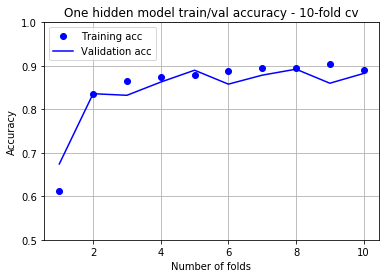

In [28]:
# Plot training/validation accuracy vs number of folds for the 10-fold cross validated model
plt.figure()
plt.plot(range(1, cv_train_acc_arr.shape[0] + 1), cv_train_acc_arr, 'bo', label='Training acc')
plt.plot(range(1, cv_val_acc_arr.shape[0] + 1), cv_val_acc_arr, 'b', label='Validation acc')
plt.ylim(0.5, 1)
plt.title('One hidden model train/val accuracy - 10-fold cv')
plt.ylabel('Accuracy')
plt.xlabel('Number of folds')
plt.grid()
plt.legend(loc='upper left')
plt.show()

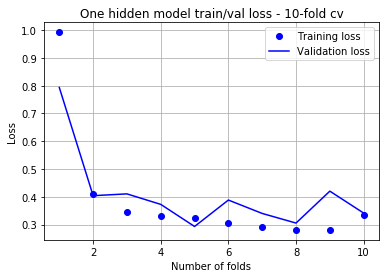

In [29]:
# Plot training/validation loss vs number of folds for the 10-fold cross validated model
plt.figure()
plt.plot(range(1, cv_train_loss_arr.shape[0] + 1), cv_train_loss_arr, 'bo', label='Training loss')
plt.plot(range(1, cv_val_loss_arr.shape[0] + 1), cv_val_loss_arr, 'b', label='Validation loss')
# plt.ylim(0, 1)
plt.title('One hidden model train/val loss - 10-fold cv')
plt.ylabel('Loss')
plt.xlabel('Number of folds')
plt.grid()
plt.legend(loc='upper right')
plt.show()

In [23]:
# When we are satisfied about the best model
# run predict on the test set.
y_pred = selected_model.predict(X_test_std)
# Reverse one-hot encoding (i.e going back to categorical variables) for the predicted targets.
# Note that argmax return indexes starting from 0, hence add 1.
y_pred_cat = np.argmax(y_pred, axis=1)
# Do the same for the true targets
y_true_cat = np.argmax(y_test, axis=1)

In [27]:
# Now that we have y_pred and y_true, we can use sklearn.metrics for precision, recall and f1-score metrics
target_names = ['Spruce/\nFir', 'Lodgepole Pine',
                'Ponderosa Pine', 'Cottonwood/\nWillow',
                'Aspen', 'Douglas-fir', 'Krummholz']
print(classification_report(y_true_cat, y_pred_cat, target_names=target_names))
# Uncomment this block to save the classification report to a csv file.
report = classification_report(y_true_cat, y_pred_cat, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
#model_filename_no_ext = os.path.splitext(model_filename)[0]
df_report.to_csv(os.path.join(os.getcwd(), f'clsreponehidden.csv'), float_format='%.4f')

                    precision    recall  f1-score   support

       Spruce/
Fir       0.76      0.71      0.73    209680
    Lodgepole Pine       0.81      0.72      0.76    281141
    Ponderosa Pine       0.78      0.73      0.76     33594
Cottonwood/
Willow       0.25      0.95      0.40       587
             Aspen       0.26      0.88      0.40      7333
       Douglas-fir       0.46      0.90      0.61     15207
         Krummholz       0.57      0.97      0.72     18350

          accuracy                           0.73    565892
         macro avg       0.56      0.84      0.62    565892
      weighted avg       0.76      0.73      0.74    565892



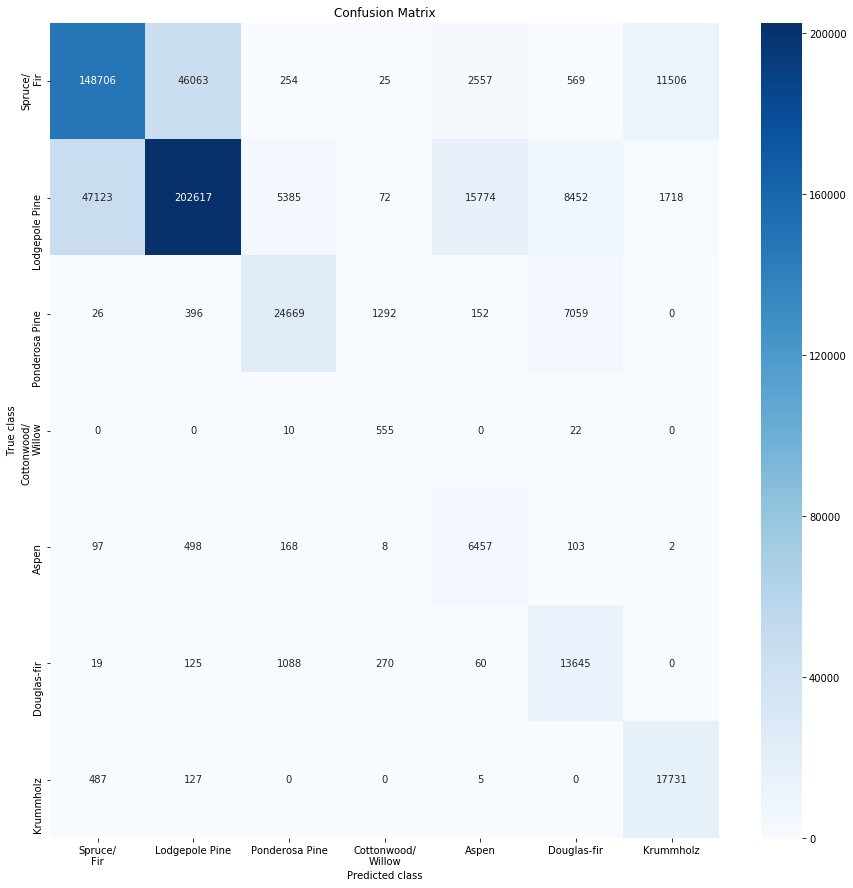

In [26]:
# Comptue the non normalized confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true_cat, y_pred_cat)
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax = ax)
ax.set_xlabel('Predicted class')
ax.set_ylabel('True class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
heatmapfig = heatmap.get_figure()
heatmapfig.savefig(f'confmat.png')